# MOQ Price Analysis for Wholesale B2B Businesses

## importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## extracting the dataset

In [2]:
df = pd.read_csv('online_retail_II.csv')
print(df.dtypes)

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


## analysing data quality

In [3]:
# finding missing data
missing_data = pd.DataFrame({
    'columns': df.columns,
    'null count': df.isnull().sum(),
    'null percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print(missing_data)

                 columns  null count  null percentage
Invoice          Invoice           0             0.00
StockCode      StockCode           0             0.00
Description  Description        4382             0.41
Quantity        Quantity           0             0.00
InvoiceDate  InvoiceDate           0             0.00
Price              Price           0             0.00
Customer ID  Customer ID      243007            22.77
Country          Country           0             0.00


In [4]:
# finding unique data
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

Invoice: 53628
StockCode: 5305
Description: 5698
Quantity: 1057
InvoiceDate: 47635
Price: 2807
Customer ID: 5942
Country: 43


In [5]:
# getting a sample of the dataset
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [6]:
# descriptive statistics from the dataset
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## identifying and documenting problems

In [7]:
# negative numbers in quantity
negative_qty = df[df['Quantity'] < 0]
print(negative_qty.head(10))

     Invoice StockCode                        Description  Quantity  \
178  C489449     22087           PAPER BUNTING WHITE LACE       -12   
179  C489449    85206A       CREAM FELT EASTER EGG BASKET        -6   
180  C489449     21895      POTTING SHED SOW 'N' GROW SET        -4   
181  C489449     21896                 POTTING SHED TWINE        -6   
182  C489449     22083         PAPER CHAIN KIT RETRO SPOT       -12   
183  C489449     21871                SAVE THE PLANET MUG       -12   
184  C489449     84946    ANTIQUE SILVER TEA GLASS ETCHED       -12   
185  C489449    84970S  HANGING HEART ZINC T-LIGHT HOLDER       -24   
186  C489449     22090          PAPER BUNTING RETRO SPOTS       -12   
196  C489459    90200A         PURPLE SWEETHEART BRACELET        -3   

             InvoiceDate  Price  Customer ID         Country  
178  2009-12-01 10:33:00   2.95      16321.0       Australia  
179  2009-12-01 10:33:00   1.65      16321.0       Australia  
180  2009-12-01 10:33:00   4.

In [8]:
# zero or negative prices in price
zero_price = df[df['Price'] <= 0]
print(zero_price.head(10))

     Invoice StockCode   Description  Quantity          InvoiceDate  Price  \
263   489464     21733  85123a mixed       -96  2009-12-01 10:52:00    0.0   
283   489463     71477         short      -240  2009-12-01 10:52:00    0.0   
284   489467    85123A   21733 mixed      -192  2009-12-01 10:53:00    0.0   
470   489521     21646           NaN       -50  2009-12-01 11:44:00    0.0   
3114  489655     20683           NaN       -44  2009-12-01 17:26:00    0.0   
3161  489659     21350           NaN       230  2009-12-01 17:39:00    0.0   
3162  489660     35956          lost     -1043  2009-12-01 17:43:00    0.0   
3168  489663    35605A       damages      -117  2009-12-01 18:02:00    0.0   
3731  489781     84292           NaN        17  2009-12-02 11:45:00    0.0   
4296  489806     18010           NaN      -770  2009-12-02 12:42:00    0.0   

      Customer ID         Country  
263           NaN  United Kingdom  
283           NaN  United Kingdom  
284           NaN  United Kingdom

In [9]:
# special codes (non-products)
special_codes = df[df['StockCode'].str.contains('^[A-Z]+$', na=False, regex=True)]
print(special_codes['StockCode'].value_counts().head(10))

StockCode
POST         2122
DOT          1446
M            1421
D             177
S             104
ADJUST         67
AMAZONFEE      43
DCGSSGIRL      25
DCGSSBOY       23
PADS           19
Name: count, dtype: int64


In [10]:
# missing customer id
no_customer = df[df['Customer ID'].isnull()]
print(no_customer.head(10))

     Invoice StockCode                   Description  Quantity  \
263   489464     21733                  85123a mixed       -96   
283   489463     71477                         short      -240   
284   489467    85123A                   21733 mixed      -192   
470   489521     21646                           NaN       -50   
577   489525    85226C     BLUE PULL BACK RACING CAR         1   
578   489525     85227   SET/6 3D KIT CARDS FOR KIDS         1   
1055  489548     22271          FELTCRAFT DOLL ROSIE         1   
1056  489548     22254          FELT TOADSTOOL LARGE        12   
1057  489548     22273          FELTCRAFT DOLL MOLLY         3   
1058  489548     22195  LARGE HEART MEASURING SPOONS         1   

              InvoiceDate  Price  Customer ID         Country  
263   2009-12-01 10:52:00   0.00          NaN  United Kingdom  
283   2009-12-01 10:52:00   0.00          NaN  United Kingdom  
284   2009-12-01 10:53:00   0.00          NaN  United Kingdom  
470   2009-12-01 

In [11]:
# missing descriptions
no_desc = df[df['Description'].isnull()]
print(no_desc.head(10))

     Invoice StockCode Description  Quantity          InvoiceDate  Price  \
470   489521     21646         NaN       -50  2009-12-01 11:44:00    0.0   
3114  489655     20683         NaN       -44  2009-12-01 17:26:00    0.0   
3161  489659     21350         NaN       230  2009-12-01 17:39:00    0.0   
3731  489781     84292         NaN        17  2009-12-02 11:45:00    0.0   
4296  489806     18010         NaN      -770  2009-12-02 12:42:00    0.0   
4566  489821    85049G         NaN      -240  2009-12-02 13:25:00    0.0   
6378  489882    35751C         NaN        12  2009-12-02 16:22:00    0.0   
6555  489898    79323G         NaN       954  2009-12-03 09:40:00    0.0   
6576  489901     21098         NaN      -200  2009-12-03 09:47:00    0.0   
6581  489903     21166         NaN        48  2009-12-03 09:57:00    0.0   

      Customer ID         Country  
470           NaN  United Kingdom  
3114          NaN  United Kingdom  
3161          NaN  United Kingdom  
3731          NaN  

In [12]:
# finding outliers in quantity
print(f"minimun quantity: {df['Quantity'].min()}")
print(f"maximun quantity: {df['Quantity'].max()}")
print(f"mean quantity: {df['Quantity'].mean()}")
print(f"99 percentile quantity: {df['Quantity'].quantile(0.99)}")
print(f"99.9 percentile quantity: {df['Quantity'].quantile(0.999)}")

minimun quantity: -80995
maximun quantity: 80995
mean quantity: 9.9388984711033
99 percentile quantity: 100.0
99.9 percentile quantity: 500.0


## cleaning the dataset

In [13]:
# getting a copy for the process
df_clean = df.copy()
print(f"number of initial records: {len(df_clean)}")

number of initial records: 1067371


In [14]:
# cleaning report
cleaning_report = {
    'step': [],
    'description': [],
    'removed count': [],
    'remaining count': []
}

def add_cleaning_step(step_name, description, removed_count, remaining_count):
    cleaning_report['step'].append(step_name)
    cleaning_report['description'].append(description)
    cleaning_report['removed count'].append(removed_count)
    cleaning_report['remaining count'].append(remaining_count)

### step 1: removing the returns

In [15]:
# counting before removing
before_q = len(df_clean)

# filtering
df_clean = df_clean[df_clean['Quantity'] > 0]

# counting after removing
after_q = len(df_clean)
removed_q = before_q - after_q

print(f"removed: {removed_q} records")
print(f"remaining: {after_q} records")

# adding to report
add_cleaning_step('step1', 'removed negative quantities', removed_q, after_q)

removed: 22950 records
remaining: 1044421 records


### step2: removing invalid prices

In [16]:
before_p = len(df_clean)

# removing negative or zero prices
df_clean = df_clean[df_clean['Price'] > 0]

after_p = len(df_clean)
removed_p = before_p - after_p

print(f"removed: {removed_p} records")
print(f"remaining: {after_p} records")

add_cleaning_step('step2', 'removed negative and zero prices', removed_p, after_p)

removed: 2750 records
remaining: 1041671 records


### step3: removing non-product stock codes

In [17]:
before_s = len(df_clean)

# identifying special code patterns
special_patterns = ['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'PADS', 'C2', 'CRUK', 'AMAZONFEE']

# removing stock codes with special patterns
df_clean = df_clean[~(df_clean['StockCode'].isin(special_patterns))]

# removing stock codes with one worded codes
df_clean = df_clean[~(df_clean['StockCode'].str.match('^[A-Z]$', na=False))]

after_s = len(df_clean)
removed_s = before_s - after_s

print(f"removed: {removed_s} records")
print(f"remaining: {after_s} records")

add_cleaning_step('step3', 'removed non-product stock codes', removed_s, after_s)

removed: 4536 records
remaining: 1037135 records


### step4: removing missing descriptions

In [18]:
before_d = len(df_clean)

df_clean = df_clean[df_clean['Description'].notna()]

after_d = len(df_clean)
removed_d = before_d - after_d

print(f"removed: {removed_d} records")
print(f"remaining: {after_d} records")

add_cleaning_step('step4', 'removed missing descriptions', removed_d, after_d)

removed: 0 records
remaining: 1037135 records


### step5: removing no customer id values

In [19]:
# finding records with no customer ids
no_customer = df_clean[df_clean['Customer ID'].isna()]

before_c = len(df_clean)

# removing no customer id records for moq strategy
df_clean = df_clean[df_clean['Customer ID'].notna()]

after_c = len(df_clean)
removed_c = before_c - after_c

print(f"removed: {removed_c} records")
print(f"remaining: {after_c} records")

add_cleaning_step('step5', 'removed records with no customer id', removed_c, after_c)

removed: 234456 records
remaining: 802679 records


### step6: managing outliers in quantity with IQR method

In [20]:
# calculating IQR
Q1 = df_clean['Quantity'].quantile(0.25)
Q3 = df_clean['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# defining bounds with (3*IQR) for extreme outliers
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

print('quantity stats')
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')
print(f'accepted bounds are from {lower_bound} to {upper_bound}')

quantity stats
Q1: 2.0
Q3: 12.0
IQR: 10.0
accepted bounds are from -28.0 to 42.0


In [21]:
# identifying outliers
outliers = df_clean[(df_clean['Quantity'] < lower_bound) | (df_clean['Quantity'] > upper_bound)]

before_o = len(df_clean)

# note: order quantities more than 10000 are considered extreme and are removed
df_clean = df_clean[df_clean['Quantity'] <= 10000]

after_o = len(df_clean)
removed_o = before_o - after_o

print(f"removed: {removed_o} records")
print(f"remaining: {after_o} records")

add_cleaning_step('step6', 'removed outliers with IQR method', removed_o, after_o)

removed: 7 records
remaining: 802672 records


### step7: cleaning and standardizing descriptions

In [22]:
# making all texts uppercase
df_clean['Description'] = df_clean['Description'].str.upper()

# removing extra spaces
df_clean['Description'] = df_clean['Description'].str.strip()

# removing extra special characters
df_clean['Description'] = df_clean['Description'].str.replace('[^\w\s]', ' ', regex=True)

# removing extra spaces
df_clean['Description'] = df_clean['Description'].str.replace('\s+', ' ', regex=True)

add_cleaning_step('step7', 'standardized descriptions', 0, after_d)

### step8: standardizing datetimes

In [23]:
# checking datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# extracting time from datetime
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# making a quarter
df_clean['Quarter'] = df_clean['InvoiceDate'].dt.quarter

# making a season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_clean['Season'] = df_clean['Month'].apply(get_season)

# invoice date ranges
print(f"invoice date range is from {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

add_cleaning_step('step8', 'fixed datetime in invoice dates', 0, 0)

invoice date range is from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


### step9: correcting data types

In [24]:
# turning all customer ids to int
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)

# turning stock codes to strings
df_clean['StockCode'] = df_clean['StockCode'].astype(str)

# turning invoices to strings
df_clean['Invoice'] = df_clean['Invoice'].astype(str)

# making price float and quantity int
df_clean['Quantity'] = df_clean['Quantity'].astype(int)
df_clean['Price'] = df_clean['Price'].astype(float)

add_cleaning_step('step9', 'corrected data types', 0, 0)

### step10: generating the total price column

In [25]:
df_clean['TotalPrice'] = (df_clean['Quantity'] * df_clean['Price']).round(2)
df_clean['TotalPrice']

0           83.40
1           81.00
2           81.00
3          100.80
4           30.00
            ...  
1067365     10.20
1067366     12.60
1067367     16.60
1067368     16.60
1067369     14.85
Name: TotalPrice, Length: 802672, dtype: float64

### step11: removing duplicates (if existing)

In [26]:
before_u = len(df_clean)

# removing duplicates
df_clean = df_clean.drop_duplicates()

after_u = len(df_clean)
removed_u = before_u - after_u

if removed_u > 0:
    add_cleaning_step('step11', 'removed existing duplicates', removed_u, after_u)


### step12: final checks and validation

In [27]:
# checking for null values
null_check = df_clean.isnull().sum()
print(f"null count: {null_check}")

null count: Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
Hour           0
Quarter        0
Season         0
TotalPrice     0
dtype: int64


In [28]:
# checking for negative values
negative_qty = (df_clean['Quantity'] < 0).sum()
negative_price = (df_clean['Price'] <= 0).sum()
print(negative_qty, negative_price)

0 0


In [29]:
# final stats
print(f"number of records: {len(df_clean)}")
print(f"number of unique customers: {df_clean['Customer ID'].nunique()}")
print(f"number of unique products: {df_clean['StockCode'].nunique()}")
print(f"number of unique invoices: {df_clean['Invoice'].nunique()}")
print(f"date range: {df_clean['InvoiceDate'].min()} -> {df_clean['InvoiceDate'].max()}")

number of records: 776617
number of unique customers: 5861
number of unique products: 4623
number of unique invoices: 36637
date range: 2009-12-01 07:45:00 -> 2011-12-09 12:50:00


In [30]:
# key stats
print("\nQuantity")
print(df_clean['Quantity'].describe())
print("\nPrice")
print(df_clean['Price'].describe())
print("\nTotalPrice")
print(df_clean['TotalPrice'].describe())


Quantity
count    776617.000000
mean         13.228294
std          67.060482
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       10000.000000
Name: Quantity, dtype: float64

Price
count    776617.000000
mean          2.939964
std           4.424447
min           0.030000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

TotalPrice
count    776617.000000
mean         21.658547
std          82.634709
min           0.060000
25%           4.950000
50%          12.450000
75%          19.800000
max       38970.000000
Name: TotalPrice, dtype: float64


### step13: documenting cleaning report

In [31]:
cleaning_df = pd.DataFrame(cleaning_report)

total_removed = df.shape[0] - df_clean.shape[0]
removal_percentage = (total_removed / df.shape[0]) * 100

print(cleaning_df.to_string(index=False))
print(f"\nnumber of initial records: {df.shape[0]}")
print(f"number of final records: {df_clean.shape[0]}")
print(f"total of removed records: {total_removed} ({removal_percentage:.1f}%)")
print(f"total of kept records: {df_clean.shape[0]} ({100 - removal_percentage:.1f}%)")

  step                         description  removed count  remaining count
 step1         removed negative quantities          22950          1044421
 step2    removed negative and zero prices           2750          1041671
 step3     removed non-product stock codes           4536          1037135
 step4        removed missing descriptions              0          1037135
 step5 removed records with no customer id         234456           802679
 step6    removed outliers with IQR method              7           802672
 step7           standardized descriptions              0          1037135
 step8     fixed datetime in invoice dates              0                0
 step9                corrected data types              0                0
step11         removed existing duplicates          26055           776617

number of initial records: 1067371
number of final records: 776617
total of removed records: 290754 (27.2%)
total of kept records: 776617 (72.8%)


### step14: exporting the cleaned data

In [32]:
# saving cleaned data to csv
df_clean.to_csv('online_retail_cleaned.csv', index=False, encoding='utf-8-sig')

# for faster importing
df_clean.to_pickle('online_retail_cleaned.pkl')

### step15: validation charts

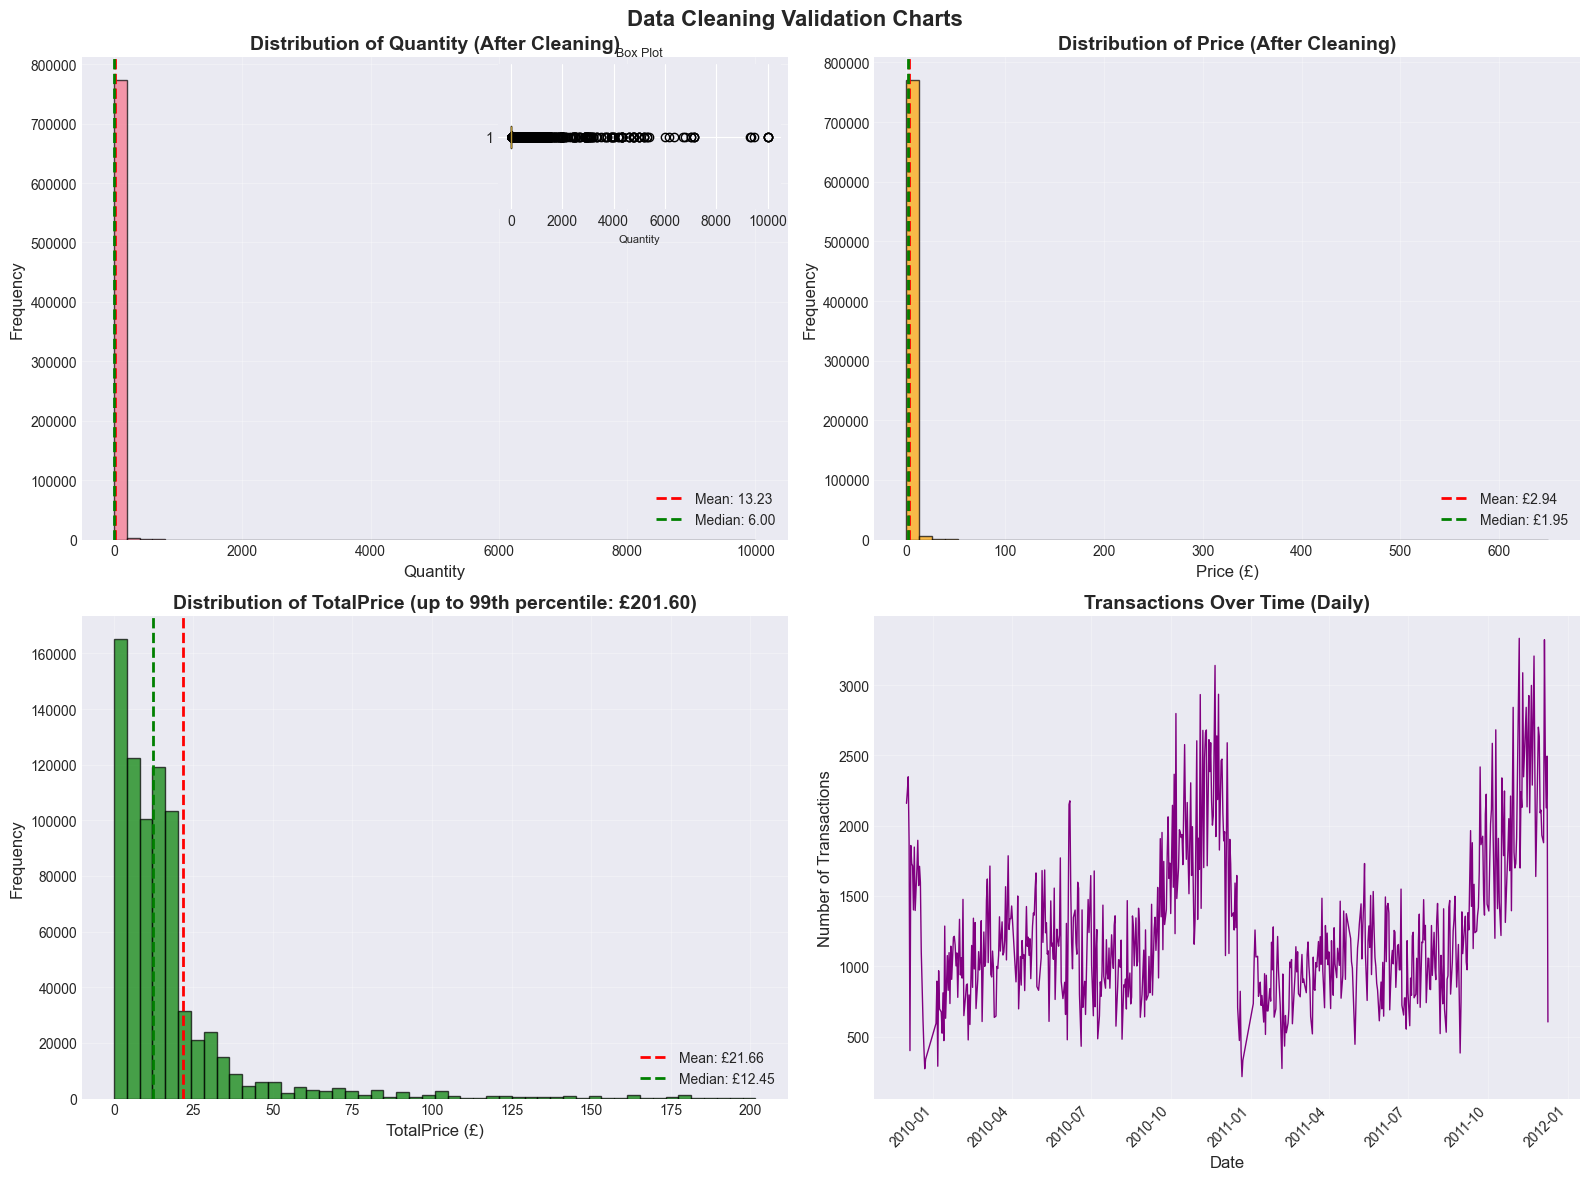

In [33]:
# validating if the extreme outliers are deleted, negative values exist and if the distrobution is normal and logical
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16,12))
fig.suptitle('Data Cleaning Validation Charts', fontsize=16, fontweight='bold')

# 1) Quantity distrobution chart
ax1 = axes[0, 0]
ax1.hist(df_clean['Quantity'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Quantity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Quantity (After Cleaning)', fontsize=14, fontweight='bold')
ax1.axvline(df_clean['Quantity'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_clean["Quantity"].mean():.2f}')
ax1.axvline(df_clean['Quantity'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_clean["Quantity"].median():.2f}')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# adding inset to box plot
axins1 = inset_axes(ax1, width="40%", height="30%", loc='upper right')
axins1.boxplot(df_clean['Quantity'], vert=False)
axins1.set_xlabel('Quantity', fontsize=8)
axins1.set_title('Box Plot', fontsize=9)


# Price distrobution chart
ax2 = axes[0, 1]
ax2.hist(df_clean['Price'], bins=50, edgecolor='black', alpha=0.7, color='orange')
ax2.set_xlabel('Price (£)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Price (After Cleaning)', fontsize=14, fontweight='bold')
ax2.axvline(df_clean['Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: £{df_clean["Price"].mean():.2f}')
ax2.axvline(df_clean['Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: £{df_clean["Price"].median():.2f}')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# TotalPrice distrobution chart
ax3 = axes[1, 0]
total_price_99 = df_clean['TotalPrice'].quantile(0.99)
df_plot = df_clean[df_clean['TotalPrice'] <= total_price_99]
ax3.hist(df_plot['TotalPrice'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('TotalPrice (£)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title(f'Distribution of TotalPrice (up to 99th percentile: £{total_price_99:.2f})', fontsize=14, fontweight='bold')
ax3.axvline(df_clean['TotalPrice'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: £{df_clean["TotalPrice"].mean():.2f}')
ax3.axvline(df_clean['TotalPrice'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: £{df_clean["TotalPrice"].median():.2f}')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# number of transactions in time chart
ax4 = axes[1, 1]
daily_transactions = df_clean.groupby(df_clean['InvoiceDate'].dt.date).size()
ax4.plot(daily_transactions.index, daily_transactions.values, linewidth=1, color='purple')
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Number of Transactions', fontsize=12)
ax4.set_title('Transactions Over Time (Daily)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# rotating the x axes
for label in ax4.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()

# saving the charts
chart_filename = 'data_cleaning_validation.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')

### step16: final validation test

In [34]:
# Final validation Tests

# list of tests
tests_passed = []
tests_failed = []

# TEST: no nulls in customer id
test_1 = 'no NULLs in customer id'
try:
    assert df_clean['Customer ID'].isna().sum() == 0, "customer id contains nulls!"
    tests_passed.append(test_1)
    print(f"✓ PASS: {test_1}")
except AssertionError as e:
    tests_failed.append((test_1, str(e)))
    print(f"✗ FAIL: {test_1} - {e}")


# TEST: no negatives in quantity
test_2 = 'no negative quantity'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_2)
    print(f"✓ PASS: {test_2}")
except AssertionError as e:
    tests_failed.append((test_2, str(e)))
    print(f"✗ FAIL: {test_2} - {e}")

# TEST: no negatives or zero prices
test_3 = 'no negative or zero prices'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_3)
    print(f"✓ PASS: {test_3}")
except AssertionError as e:
    tests_failed.append((test_3, str(e)))
    print(f"✗ FAIL: {test_3} - {e}")

# TEST: TotalPrice calculated correctly
test_4 = 'correct total price'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_4)
    print(f"✓ PASS: {test_4}")
except AssertionError as e:
    tests_failed.append((test_4, str(e)))
    print(f"✗ FAIL: {test_4} - {e}")

# TEST: no complete duplicates
test_5 = 'no complete duplicates'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_5)
    print(f"✓ PASS: {test_5}")
except AssertionError as e:
    tests_failed.append((test_5, str(e)))
    print(f"✗ FAIL: {test_5} - {e}")

# TEST: quantity in accepted range
test_6 = 'quantity in accepted range'
try:
    assert df_clean['Quantity'].min() >= 1, f"minimum quantity is {df_clean['Quantity'].min()}"
    assert df_clean['Quantity'].max() <= 10000, f"maximum quantity is {df_clean['Quantity'].max()}"
    tests_passed.append(test_6)
    print(f"✓ PASS: {test_6}")
except AssertionError as e:
    tests_failed.append((test_6, str(e)))
    print(f"✗ FAIL: {test_6} - {e}")

# TEST: invoice in accepted range
test_7 = 'invoice in accepted range'
try:
    min_date = df_clean['InvoiceDate'].min()
    max_date = df_clean['InvoiceDate'].max()
    assert min_date >= pd.Timestamp('2009-01-01'), f"Earliest date {min_date} is before 2009"
    assert max_date <= pd.Timestamp('2012-01-01'), f"Latest date {max_date} is after 2011"
    tests_passed.append(test_7)
    print(f"✓ PASS: {test_7}")
except AssertionError as e:
    tests_failed.append((test_7, str(e)))
    print(f"✗ FAIL: {test_7} - {e}")

✓ PASS: no NULLs in customer id
✓ PASS: no negative quantity
✓ PASS: no negative or zero prices
✓ PASS: correct total price
✓ PASS: no complete duplicates
✓ PASS: quantity in accepted range
✓ PASS: invoice in accepted range


In [35]:
# overall tests review
if tests_failed:
    print(f"Number of Failed Tests: {len(tests_failed)}")
    print(f"\nFailed Tests:")
    for test, error in tests_failed:
        print(f"test: {test}, error: {error}")
else:
    print("ALL TESTS PASSED")

ALL TESTS PASSED


## Checking Metrics for EDA

In [ ]:
# Loading the Cleaned DataFrame
df = pd.read_pickle('online_retail_cleaned.pkl')

# Calculating the invoice_level metrics
invoice_metrics = df.groupby('Invoice').agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum'
})